In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [16]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct  1 04:26:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [18]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random




from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD 



#embedding
from gensim.models import Word2Vec

# tqdm
from tqdm.notebook import tqdm

#tensorflow
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Embedding, Flatten,Dense
from tensorflow import keras
import tensorflow_addons as tfa
from keras import backend as K

#os
import os



In [51]:
train_file_path = "/content/drive/MyDrive/assign2/comp90051-22-s2-authorship/train.json"
test_file_path = "/content/drive/MyDrive/assign2/comp90051-22-s2-authorship/test.json"

with open(train_file_path, 'r') as f:
    data = json.load(f)
df_train = pd.DataFrame(data)

with open(test_file_path, 'r') as f:
    data = json.load(f)
df_test = pd.DataFrame(data)

In [56]:
# author feature is used to retreive the corresponding labels and the coauthor feature is used for further training

# Retrive the non-prolific author and prolific author index
non_prolific_author_index = []
prolific_author_index = []
for i,j in enumerate(df_train['authors']):
  sum = 0
  for k in j:
    if k < 100 and k >= 0:
      sum += 1
  if sum == 0:
    non_prolific_author_index.append(i)
  else:
    prolific_author_index.append(i)

df_non_prolifc_authors = df_train.drop(prolific_author_index)
df_prolific_authors = df_train.drop(non_prolific_author_index)


# create a new column for coauthor of prolific author dataframe
prolific_author_label = []
non_prolific_author_label = []
for i in df_prolific_authors['authors']:
  prolific_author_label_each_instance = []
  non_prolific_author_label_each_instance = []
  for j in i:
    if j >= 0 and j < 100:
      prolific_author_label_each_instance.append(j)
    else:
      non_prolific_author_label_each_instance.append(j)
  prolific_author_label.append(prolific_author_label_each_instance)
  non_prolific_author_label.append(non_prolific_author_label_each_instance)

#Creat a new column for futher training features

df_prolific_authors['coauthors'] = non_prolific_author_label

# get the corresponding percentage of non prolific author
selected_col_nums = 2500
non_prolific_author_rows =[]

for i in range(selected_col_nums):
  non_prolific_author_rows.append(random.randint(0,18333))

df_selected_non_prolific_authors = df_non_prolifc_authors.iloc[non_prolific_author_rows]
df_selected_non_prolific_authors['coauthors'] = df_selected_non_prolific_authors.loc[:,'authors']


df_prolific_authors_25_non_prolific = pd.concat([df_selected_non_prolific_authors, df_prolific_authors], axis = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:

df_prolific_authors_25_non_prolific


,authors,year,abstract,venue,title,coauthors
12257,"[16217, 19572, 1032, 15763]",9,"[1930, 1953, 1536, 1542, 33, 4162, 2355, 10, 3...",3,"[1943, 1543, 1627, 1999, 1576, 2260, 1553, 193...","[16217, 19572, 1032, 15763]"
9725,"[13700, 6589, 14887, 16284, 9437, 9290, 16108,...",4,"[46, 1605, 1691, 10, 1557, 1662, 1535, 2430, 1...",,"[1533, 48, 1585, 11, 3524, 1564, 1661, 1540, 1...","[13700, 6589, 14887, 16284, 9437, 9290, 16108,..."
22505,"[2450, 17426, 11743, 1478]",18,"[37, 2067, 4336, 1525, 2185, 2163, 1866, 4516,...",9,"[41, 1657, 1534, 47, 2055, 24, 46, 46, 3575, 1...","[2450, 17426, 11743, 1478]"
5327,"[16668, 16288, 2561, 9846, 6419, 3381]",12,"[1731, 1662, 1691, 4799, 1535, 2279, 3661, 311...",138,"[37, 2074, 1538, 1735, 3186, 1532, 34, 40, 160...","[16668, 16288, 2561, 9846, 6419, 3381]"
13233,"[11149, 19921, 7646, 19398, 1025]",8,"[1731, 1959, 1651, 3129, 1543, 1535, 2293, 175...",11,"[46, 1546, 2099, 11, 3524, 1594, 46, 1670, 154...","[11149, 19921, 7646, 19398, 1025]"
...,...,...,...,...,...,...
25767,"[19974, 68, 8903]",1,"[40, 1542, 1691, 2449, 1535, 2855, 1549, 1755,...",23,"[1708, 33, 58, 57, 2174, 1548, 1538, 1553, 359...","[19974, 8903]"
25776,"[6353, 67, 3037, 15856, 13521]",10,"[40, 1542, 1691, 2907, 1540, 1535, 2121, 2431,...",10,"[53, 2555, 4480, 1535, 1637, 1898, 1549, 53, 3...","[6353, 3037, 15856, 13521]"
25778,"[7686, 3810, 87, 7451]",16,"[2144, 1661, 2151, 1966, 3776, 4864, 1546, 219...",31,"[1615, 1966, 11, 3238, 1653, 3318, 24, 2144, 1...","[7686, 3810, 7451]"
25781,"[14864, 92]",16,"[37, 1662, 33, 1814, 2036, 1692, 1553, 2333, 2...",0,"[46, 1670, 1826, 37, 1632, 46, 1991, 1525, 152...",[14864]


In [58]:
total_label = []
for i in df_prolific_authors_25_non_prolific['authors']:
  label_each_instance = []
  for j in i:
    if j >= 0 and j < 100:
      label_each_instance.append(j)
  total_label.append(label_each_instance)


In [59]:
total_label[3000]

[27]

In [60]:
#One-hot encoding the labels
multilable_binarizer = MultiLabelBinarizer()
ohe_prolific_labels = multilable_binarizer.fit_transform(total_label).astype('float')

In [61]:
ohe_prolific_labels[100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Word2Vec

In [80]:
def convert_to_string(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(str(j))
    total_list.append(per_instance)
  return total_list


def convert_to_num(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(j)
    total_list.append(per_instance)
  return total_list

# word to vec title model
string_title = convert_to_string(df_train['title'])
# Word2Vec
model_title = Word2Vec(string_title, min_count=1)
print(model_title)











Word2Vec(vocab=3444, size=100, alpha=0.025)


In [78]:
type(df_train['title'][0])

list

In [81]:
# word to vec coauthor model
string_coauthor = convert_to_string(df_train['authors'])

model_coauthor = Word2Vec(string_coauthor, min_count=1)
print(model_coauthor)

Word2Vec(vocab=20433, size=100, alpha=0.025)


In [82]:
# word to vec abstract model
string_abstract = convert_to_string(df_train['abstract'])
# Word2Vec

model_abstract = Word2Vec(string_abstract, min_count=1,workers=4)
print(model_abstract)

Word2Vec(vocab=4845, size=100, alpha=0.025)


In [23]:
string_abstract = convert_to_string(df_train['abstract'])

In [16]:
print(model_abstract.similarity('1', '2'))

0.36800963


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [60]:
model_abstract.wv['1']

array([-1.4585125e-02, -4.9507526e-01, -5.7288754e-01,  9.7955912e-01,
        2.6489365e-01, -1.2819332e-01,  2.8234828e-01,  2.6662230e-01,
       -1.1838480e-01,  1.8767974e-01,  5.3904080e-01,  7.6374042e-01,
       -3.8932884e-01, -3.2113820e-01, -1.7080314e-01,  1.6933297e+00,
        1.6835083e-01, -2.1455999e-02,  5.8086783e-02, -1.4915175e+00,
       -1.4530808e-01,  9.7644433e-02, -1.0873696e+00,  5.4729369e-02,
       -1.0224370e-01, -1.2627807e+00,  4.6923599e-01, -1.7403828e-01,
       -5.3643101e-01, -8.5532510e-01,  9.2136258e-01,  4.2069572e-01,
        4.4881791e-01, -1.0795524e-01,  6.3800983e-02, -3.8747343e-01,
       -4.6109316e-01, -3.5838169e-01,  7.3813371e-02, -5.5391479e-02,
        6.1840016e-01, -7.0899135e-01, -5.0981350e-02, -7.7799416e-01,
        1.2388848e+00,  3.8164669e-01,  1.3891292e-01, -5.0809234e-01,
        7.0885926e-01, -3.7789607e-01,  9.6797359e-01, -5.7110304e-01,
       -5.9669751e-01, -5.4595417e-01,  7.2006125e-04, -9.4210304e-02,
      

In [ ]:
from gensim.models.keyedvectors import KeyedVectors








#Tensorflow


In [67]:
def convert_to_string(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(str(j))
    total_list.append(per_instance)
  return total_list

# Handle the situation where the coauthor is zero
def convert_to_num(df):
  total_list = []
  for i in df:
    per_instance = []
    for j in i:
      per_instance.append(j)
    if len(per_instance) == 0:
      per_instance.append(21246)
    total_list.append(per_instance)
  return total_list

In [68]:
num_coauthor = convert_to_num(df_prolific_authors_25_non_prolific['coauthors'])
num_abstract = convert_to_num(df_prolific_authors_25_non_prolific['abstract'])
num_title = convert_to_num(df_prolific_authors_25_non_prolific['title'])

In [69]:
max_length_coauthor = max([len(i)for i in num_coauthor])
max_length_abstract = max([len(i)for i in num_abstract])
max_length_title = max([len(i)for i in num_title])
print('max_length_coauthor' ,max_length_coauthor)
print('max_length_abstract ',max_length_abstract)
print('max_length_title ', max_length_title)

max_length_coauthor 100
max_length_abstract  2804
max_length_title  121


In [70]:
min([len(i)for i in num_coauthor])
  



1

In [71]:
len(num_coauthor)

9960

In [72]:
max_length_coauthor = max([len(i)for i in num_coauthor])

In [73]:
padded_coauthor = pad_sequences(num_coauthor,truncating = 'post',maxlen = 100,padding ='post')
padded_title = pad_sequences(num_title,truncating = 'post',maxlen = 20,padding ='post')
padded_abastract = pad_sequences(num_abstract,truncating = 'post',maxlen = 64,padding ='post')

In [428]:
embedding_dimension = 128
vocabulary_size_title_abstract = 5000
vocabulary_size_coauthor = 21247
max_length_abstract = 64
max_length_title = 20
max_length_coauthor = 100




In [523]:
checkpoint_path = 'model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                              save_best_only=True,
                                              monitor = 'val_f1_score',
                                              mode='max')


def create_model():
  # abstract = layers.Embedding(input_dim = vocabulary_size_title_abstract, output_dim = embedding_dimension,mask_zero=True,input_length = max_length_abstract)
  coauthor = layers.Embedding(input_dim = vocabulary_size_coauthor, output_dim = embedding_dimension,mask_zero=True,input_length = max_length_coauthor)
  # title = layers.Embedding(input_dim = vocabulary_size_title_abstract, output_dim = embedding_dimension,input_length = max_length_title)
  # concatenated_layer = layers.Concatenate(axis=1)([abstract, coauthor,title])
  classification_model = tf.keras.Sequential([
      coauthor,
      layers.GlobalAveragePooling1D(),
      layers.Dense(128, activation="relu"),
      layers.Dropout(0.5),
      # layers.Dense(128, activation="relu"),
      # layers.Dropout(0.1),
      layers.Dense(100,activation="sigmoid"),
      
  ])
  return classification_model

model = create_model()
model.summary()


inputs_abstract = keras.Input((max_length_abstract))
inputs_coauthor = keras.Input((max_length_coauthor))
inputs_title = keras.Input((max_length_title))

abstract_embed_layer = layers.Embedding(input_dim = vocabulary_size_title_abstract, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_abstract, embeddings_regularizer= tf.keras.regularizers.L2(0.01))(inputs_abstract)
average_pool1 = layers.GlobalAveragePooling1D()(abstract_embed_layer)

coauthor_embed_layer = layers.Embedding(input_dim = vocabulary_size_coauthor,mask_zero=True, output_dim = embedding_dimension,input_length = max_length_coauthor)(inputs_coauthor)
average_pool2 = layers.GlobalAveragePooling1D()(coauthor_embed_layer)

title_embed_layer = layers.Embedding(input_dim = vocabulary_size_title_abstract, mask_zero=True, output_dim = embedding_dimension,input_length = max_length_title, embeddings_regularizer= tf.keras.regularizers.L2(0.01))(inputs_title)
average_pool3 = layers.GlobalAveragePooling1D()(title_embed_layer)

concatenated_layer = layers.Concatenate(axis = 1)([average_pool1, average_pool2,average_pool3])
# average_pool = layers.GlobalAveragePooling1D()(concatenated_layer)
x1 = layers.Dense(128, activation="relu")(concatenated_layer)
# x2 = layers.Dropout(0.1)(x1)
# x3 = layers.Dense(128, activation="relu") (x2)
x4 = layers.Dropout(0.5) (x1)
x5 = layers.Dense(100,activation="sigmoid") (x4)
model = keras.Model([inputs_abstract,inputs_coauthor,inputs_title],x5)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_236 (Embedding)   (None, 100, 128)          2719616   
                                                                 
 global_average_pooling1d_23  (None, 128)              0         
 6 (GlobalAveragePooling1D)                                      
                                                                 
 dense_171 (Dense)           (None, 128)               16512     
                                                                 
 dropout_89 (Dropout)        (None, 128)               0         
                                                                 
 dense_172 (Dense)           (None, 100)               12900     
                                                                 
Total params: 2,749,028
Trainable params: 2,749,028
Non-trainable params: 0
___________________________________________

In [524]:
X_train,X_test,y_train,y_test = train_test_split(padded_coauthor,ohe_prolific_labels,test_size=0.1,random_state=90051)

In [525]:
metrics = tfa.metrics.F1Score(num_classes=100,threshold = 0.6, average='macro')
loss = tf.keras.losses.BinaryFocalCrossentropy(gamma=2,from_logits=False)
# loss = tf.keras.losses.CategoricalCrossentropy()
# metrics= ['categorical_accuracy']
# def calculating_class_weights(y_true):
#     from sklearn.utils.class_weight import compute_class_weight
#     number_dim = np.shape(y_true)[1]
#     weights = np.empty([number_dim, 2])
#     for i in range(number_dim):
#         weights[i] = compute_class_weight(class_weight ='balanced', classes = np.unique(y_true[:, i]), y = y_true[:, i])
#     return weights

# weights = calculating_class_weights(ohe_prolific_labels)
# # print(weights)
# def get_weighted_loss(weights):
#     def weighted_loss(y_true, y_pred):
#         return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
#     return weighted_loss

# metrics = tf.keras.metrics.TopKCategoricalAccuracy(k = 3)
loss = tf.keras.losses.BinaryFocalCrossentropy()
optimizer = optimizers.Adam(learning_rate =0.001)
model.compile(loss= loss, optimizer= optimizer, metrics = metrics)
history = model.fit([padded_abastract,padded_coauthor,padded_title],ohe_prolific_labels, epochs = 50, batch_size= 64,callbacks = [callback], validation_split=0.1,shuffle = True)


# history = model.fit(X_train,y_train, epochs = 20, batch_size= 32,callbacks = [callback], validation_data = (X_test,y_test),shuffle = True)

Epoch 1/50
131/141 [==========================>...] - ETA: 0s - loss: 1.2033 - f1_score: 0.0000e+00
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to model/cp.ckpt
141/141 [==============================] - 2s 7ms/step - loss: 1.1266 - f1_score: 0.0000e+00 - val_loss: 0.0215 - val_f1_score: 0.0000e+00
Epoch 2/50
133/141 [===========================>..] - ETA: 0s - loss: 0.0159 - f1_score: 0.0000e+00
Epoch 2: val_f1_score did not improve from 0.00000
141/141 [==============================] - 1s 5ms/step - loss: 0.0158 - f1_score: 0.0000e+00 - val_loss: 0.0205 - val_f1_score: 0.0000e+00
Epoch 3/50
132/141 [===========================>..] - ETA: 0s - loss: 0.0148 - f1_score: 0.0000e+00
Epoch 3: val_f1_score did not improve from 0.00000
141/141 [==============================] - 1s 5ms/step - loss: 0.0147 - f1_score: 0.0000e+00 - val_loss: 0.0197 - val_f1_score: 0.0000e+00
Epoch 4/50
133/141 [===========================>..] - ETA: 0s - loss: 0.0136 - f1_score: 0.0000e+0

In [526]:
model.load_weights(checkpoint_path)


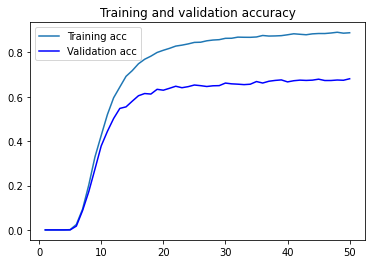

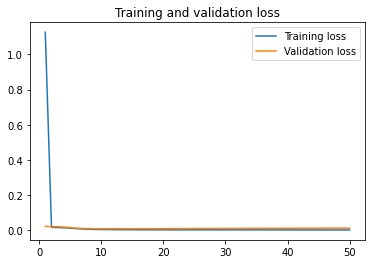

In [527]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [528]:
y_pred = model.predict(X_test)

ValueError: ignored

In [ ]:
# for i in range()
predicted_train = np.where(y_pred < 0.4, 0, 1)
f1_score(y_test, predicted_train, average='samples')

## Test set

In [538]:
test_num_coauthor = convert_to_num(df_test['coauthors'])
test_padded_coauthor = pad_sequences(test_num_coauthor,truncating = 'post',maxlen = 100,padding ='post')

test_num_abstract = convert_to_num(df_test['abstract'])
test_padded_abstract = pad_sequences(test_num_abstract,truncating = 'post',maxlen = 64,padding ='post')

test_num_title = convert_to_num(df_test['title'])
test_padded_title = pad_sequences(test_num_title,truncating = 'post',maxlen = 20,padding ='post')

In [539]:

y_pred = model.predict([test_padded_abstract,test_padded_coauthor,test_padded_title])

# y_pred = model.predict(test_padded_coauthor)

In [540]:
y_pred[1]

array([0.01031784, 0.0179459 , 0.580484  , 0.07266914, 0.01038411,
       0.01100261, 0.04594078, 0.0098298 , 0.01807493, 0.01559474,
       0.02919169, 0.01159392, 0.06921639, 0.02025088, 0.04008298,
       0.08493907, 0.00257371, 0.17942528, 0.03907467, 0.01275505,
       0.04964445, 0.0042192 , 0.00975496, 0.01120738, 0.01494485,
       0.01417581, 0.03790718, 0.03373526, 0.05263007, 0.0102262 ,
       0.00696543, 0.03250299, 0.05441676, 0.0167115 , 0.00903517,
       0.01324079, 0.02830571, 0.01541235, 0.01704719, 0.01213375,
       0.0190105 , 0.03033962, 0.05250385, 0.00443648, 0.03680164,
       0.05839882, 0.01949837, 0.01712076, 0.01898897, 0.01666038,
       0.01398413, 0.06097861, 0.05622933, 0.0299682 , 0.01491442,
       0.03521306, 0.00076247, 0.01631052, 0.00241538, 0.03557862,
       0.05656205, 0.03259054, 0.16918801, 0.00074577, 0.11537518,
       0.04739936, 0.10702456, 0.01710534, 0.00278877, 0.00620273,
       0.01038609, 0.02932751, 0.03292011, 0.07827269, 0.04683

In [541]:

prediction = np.where(y_pred < 0.2, 0, 1)

In [542]:
prediction[1]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [543]:
predicted_list = [i.tolist() for i in prediction]
total_index_list = []
for i in predicted_list:
  index_list = []
  for j,k in enumerate(i):
    if k == 1:
        index_list.append(str(j))
  if len(index_list) != 0:
    total_index_list.append(index_list)
  else:
    total_index_list.append([str(-1)])

predicted_str = []
for i in total_index_list:
  a = ','.join(i)
  predicted_str.append(a)

In [544]:

df_output = pd.DataFrame({'ID': list(range(800)),'Predict':predicted_str})
df_output.to_csv('predicted_result.csv',index = False)

In [545]:

df_output['Predict'].values.tolist().count('-1') / 800

0.31

In [546]:

df_output

,ID,Predict
0,0,92
1,1,2
2,2,31
3,3,23
4,4,32
...,...,...
795,795,54
796,796,97
797,797,"13,71"
798,798,71
